<a href="https://colab.research.google.com/github/usneek/sequence-embeddings/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code file has used Autoencoder to generate sequence embeddings. Encoder part of an autoencoder extracts features which can be used as embeddings

# **Importing**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# **Data Preprocessing**

The steps required will be:-

1. To convert date of logs in YYYY-MM-DD fromat so they can be sorted in chronological order.
2.Next step is to fill empty cells in the column ModuleCode with Assessment Code
3.Then for each user we will create list of activities they attempted in order of date i.e. the sequence of activities.
4.Then we will rwmove those columns which don't have complete information about them i.e. if they passed or failed the course.
5.Then we will use LabelEncoder() to label the output values.
6.Finally we split the data into train, validation and test set in 3:1:1

In [ ]:
corpus=pd.read_csv("drive/MyDrive/Data/course_usage_anon.csv")
corpus['AttemptDate']=pd.to_datetime(corpus['AttemptDate'])
corpus=corpus.sort_values(by="AttemptDate")
corpus['ModuleCode'] = corpus['ModuleCode'].fillna(corpus['AssessmentCode'])

In [ ]:
x1=corpus.groupby(by="UserID")["ModuleCode"].apply(list)
x1=x1.reset_index(name="sequence")
x1.columns=["id","sequence"]

In [ ]:
corpus=corpus.dropna(subset=["PassFail"])
x2=corpus.groupby(by="UserID")["PassFail"].mean()
x2=x2.reset_index(name="PassFail")
x2.columns=["id","PassFail"]

In [ ]:
corpus=x1.join(x2,rsuffix='id',how="inner")

In [ ]:
x=corpus["sequence"]
y = corpus["PassFail"]
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
x_train,x_test,y_train,y_test=train_test_split(x,encoded_y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=0)

# **Creating embeddings using Autoencoders**

Tokenizer is used to convert our sequnence into numerical values which we can use further to input in encoder.

The maximum different words in the sequence are 25 and we will pad the sequences to a fixed length of 30.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words =25, split=',')
tokenizer.fit_on_texts(x_train)
seqs = tokenizer.texts_to_sequences(x_train)
pad_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 30)
seqs_val= tokenizer.texts_to_sequences(x_val)
pad_seqs_val = tf.keras.preprocessing.sequence.pad_sequences(seqs_val, 30)

In the autoencoder, encoder part has Embedding layer followed by Bidirectional LSTM

The decoder part has unidirectional LSTM layer followed by softmax to reconstruct the output.

In [ ]:
encoder_input=Input(shape=(30,))
encoder_input_2=Embedding(25,30,input_length = 30,mask_zero=False)(encoder_input)
encoder_output=Bidirectional(LSTM(3,activation="relu"))(encoder_input_2)
encoder_model = tf.keras.Model(encoder_input, encoder_output)
decoded = RepeatVector(30)(encoder_output)
decoder_output=LSTM(6,return_sequences=True)(decoded)
decoder_output_2=Dense(25,activation="softmax")(decoder_output)
model=tf.keras.Model(encoder_input,decoder_output_2)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Exceuting autoencoder**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(filepath='drive/MyDrive/Data/Autoencoder/model.{epoch:02d}-{val_loss:.2f}.h5',
                                            save_weights_only = True,
                                            period = 1,
                                            verbose = 1,
                                            save_best_only=False)
history=model.fit(pad_seqs, pad_seqs , validation_data=(pad_seqs_val,pad_seqs_val),batch_size=128, epochs=100,callbacks=[model_checkpoint_callback])

Epoch 1/100
24/24 [==============================] - 6s 73ms/step - loss: 3.1978 - accuracy: 0.4265 - val_loss: 3.1680 - val_accuracy: 0.5131

Epoch 00001: saving model to drive/MyDrive/Data/Autoencoder/model.01-3.17.h5
Epoch 2/100
24/24 [==============================] - 1s 41ms/step - loss: 3.1193 - accuracy: 0.5186 - val_loss: 3.0428 - val_accuracy: 0.5185

Epoch 00002: saving model to drive/MyDrive/Data/Autoencoder/model.02-3.04.h5
Epoch 3/100
24/24 [==============================] - 1s 43ms/step - loss: 2.8978 - accuracy: 0.5185 - val_loss: 2.6759 - val_accuracy: 0.5219

Epoch 00003: saving model to drive/MyDrive/Data/Autoencoder/model.03-2.68.h5
Epoch 4/100
24/24 [==============================] - 1s 44ms/step - loss: 2.4802 - accuracy: 0.5190 - val_loss: 2.3374 - val_accuracy: 0.5267

Epoch 00004: saving model to drive/MyDrive/Data/Autoencoder/model.04-2.34.h5
Epoch 5/100
24/24 [==============================] - 1s 42ms/step - loss: 2.2601 - accuracy: 0.5215 - val_loss: 2.1725 -

**Plotting training and validation loss to decide the epoch number after which weights should be taken**

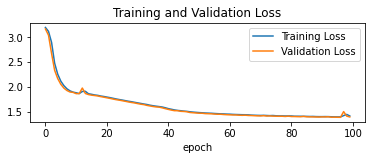

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Selecting the weights of 97th epoch**

In [ ]:
model.load_weights('drive/MyDrive/Data/Autoencoder/model.97-1.39.h5')

**Final Embeddings egenerated**

In [ ]:
embeddings = encoder_model.predict(pad_seqs)
embeddings_val=encoder_model.predict(pad_seqs_val)

# **Evaluation**

1. We will train a classifier in keras to predict the output of each sequence embedding as pass/fail.
2. We will predict our accuracy and F1 score on test set to measure the efficeincy of our embeddings

In [ ]:
classifier = Sequential()
classifier.add(Dense(64, input_shape = (embeddings.shape[1],))) 
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
model_checkpoint_callback = ModelCheckpoint(filepath='drive/MyDrive/Data/Autoencoder/model.{epoch:02d}-{val_loss:.2f}.h5',
                                            save_weights_only = True,
                                            period = 1,
                                            verbose = 1,
                                            save_best_only=False)
history=classifier.fit(embeddings, y_train ,validation_data=(embeddings_val,y_val),batch_size=128, epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
24/24 [==============================] - 1s 14ms/step - loss: 1.2398 - accuracy: 0.5720 - val_loss: 0.7576 - val_accuracy: 0.7762

Epoch 00001: saving model to drive/MyDrive/Data/Autoencoder/model.01-0.76.h5
Epoch 2/30
24/24 [==============================] - 0s 5ms/step - loss: 0.8884 - accuracy: 0.6564 - val_loss: 0.5641 - val_accuracy: 0.7762

Epoch 00002: saving model to drive/MyDrive/Data/Autoencoder/model.02-0.56.h5
Epoch 3/30
24/24 [==============================] - 0s 5ms/step - loss: 0.7567 - accuracy: 0.6499 - val_loss: 0.5518 - val_accuracy: 0.7762

Epoch 00003: saving model to drive/MyDrive/Data/Autoencoder/model.03-0.55.h5
Epoch 4/30
24/24 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6780 - val_loss: 0.5546 - val_accuracy: 0.7762

Epoch 00004: saving model to drive/MyDrive/Data/Autoencoder/model.04-0.55.h5
Epoch 5/30
24/24 [==============================] - 0s 5ms/step - loss: 0.6546 - accuracy: 0.6983 - val_loss: 0.5628 - val_accu

**Plotting training and validation loss to decide the epoch number after which weights should be taken**

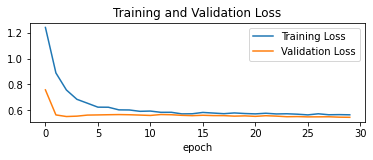

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Deciding 21 as epoch number**

In [ ]:
classifier.load_weights('drive/MyDrive/Data/Autoencoder/model.21-0.55.h5')

**Predicting the test score**

In [ ]:
seqs_test = tokenizer.texts_to_sequences(x_test)
pad_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(seqs_test, 30)
embeddings_test = encoder_model.predict(pad_seqs_test)

In [ ]:
predictions=classifier.predict(embeddings_test)
rounded=[round(x[0]) for x in predictions]

In [ ]:
acc=accuracy_score(rounded,y_test)
f1=f1_score(y_test, rounded)
print("Accuracy is ",acc)
print("f1 score is ",f1)

Accuracy is  0.7643979057591623
f1 score is  0.8664688427299704
